In [1]:
import os
import sys
import argparse
from os.path import dirname, realpath


In [2]:
sys.path.append("./src/")
sys.path.append(dirname(dirname(realpath(os.getcwd()))))

In [3]:
%run load_12_16.py

In [4]:
[sum(gold1), sum(gold2), sum(gold3), sum(gold4)]

[432, 211, 119, 58]

In [5]:
537+ 272+ 138+ 87

1034

In [85]:
wts01 = np.where(gold1 == 1, sum(gold0)**.5  /(  (1-mp1) ), 1/ mp1)
wts02 = np.where(gold2 == 1, sum(gold0*2)**.5  /(  (1-mp2)/2 ), 1/ mp2)
wts03 = np.where(gold3 == 1, sum(gold0*3)**.5  /(  (1-mp3)/3 ), 1/ mp3)
wts04 = np.where(gold4 == 1, sum(gold0*4)**.5  /(  (1-mp4)/4 ), 1/ mp4)



In [86]:
wts1234 = np.concatenate((wts01,wts02, wts03, wts04))
y1234 = np.concatenate((gold1,gold2, gold3, gold4))
lo1234 = logit( np.concatenate((mp1,mp2, mp3, mp4)) )
tlo1234 = logit( np.concatenate((tp1,tp2, tp3, tp4)) )
ti = np.concatenate((np.ones(len(mp1)), 2*np.ones(len(mp2)), 3*np.ones(len(mp3)), 4*np.ones(len(mp4))))
tti = np.concatenate((np.ones(len(tp1)), 2*np.ones(len(tp2)), 3*np.ones(len(tp3)), 4*np.ones(len(tp4))))

In [87]:
def weighted_temp2_scaling (logits, y, wts):
    def temperature_obj(t):
        temp_logits =   (logits  ) /  t [0]  + t[1]
        probs = expit(temp_logits)
        return log_loss(y, probs, sample_weight=wts)    
    res = minimize (temperature_obj,x0 = [.1,.1])
    return res.x
def temp_pred2 (alpha,  test_logit):    
    logi =  (test_logit  )/ alpha[0]    + alpha[1]
    proba = expit ( logi   ) #*tt.x[5]    
    return proba

In [88]:
alpha_0_1234  = weighted_temp2_scaling(  lo1234 , y1234,  wts1234)
pc = temp_pred2(alpha_0_1234, lo1234 )

(array([21360.,  9204.,  6652.,  4179.,  2570.,  1637.,  1196.,   777.,
          363.,    75.]),
 array([0.00759943, 0.08413291, 0.16066639, 0.23719987, 0.31373335,
        0.39026683, 0.46680031, 0.54333378, 0.61986726, 0.69640074,
        0.77293422]),
 <BarContainer object of 10 artists>)

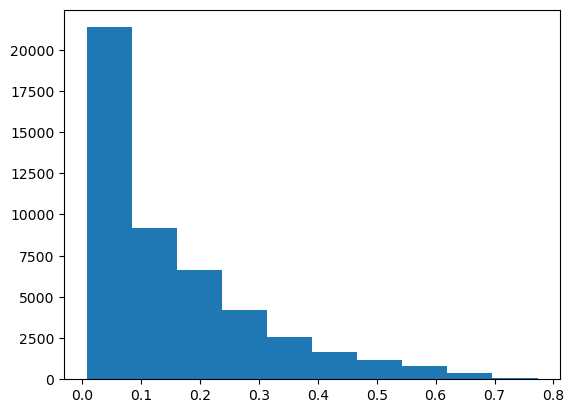

In [89]:
plt.hist(pc)

In [90]:
wp1 = ( pc [ti==1])**1
wp2 = ( pc [ti==2]) **1
wp3 = ( pc [ti==3]) **1
wp4 =  (pc [ti==4])**1
np1 =  ((1-pc) [ti==1])**1
np2 =  ((1-pc) [ti==2])**1
np3 =  ((1-pc) [ti==3])**1
np4 =  ((1-pc) [ti==4])**1

wts1 = np.where(gold1 == 1, 1/( np1 *np.mean(gold1)**1), 1/wp1)
wts2 = np.where(gold2 == 1, 1/( np2 *np.mean(gold2)**1), 2/wp2)
wts3 = np.where(gold3 == 1, 1/( np3 *np.mean(gold3)**1), 3/wp3 )
wts4 = np.where(gold4 == 1, 1/( np4 *np.mean(gold4)**1), 4/wp4 )

In [91]:
wts1 = np.where(gold1 == 1,  (sum(gold1)**.5)/( np1 ), 1/(wp1))
wts2 = np.where(gold2 == 1,  (sum(gold2*2)**.5)/( np2/2 ),1/(wp2))
wts3 = np.where(gold3 == 1,  (sum(gold3*3)**.5)/( np3 /3), 1/(wp3))
wts4 = np.where(gold4 == 1,  (sum(gold4*4)**.5)/( np4 /4), 1/wp4)



In [92]:
def temperature_multi_w(l1, l2,l3,l4, y1, y2, y3, y4, w1, w2, w3, w4):
    def temperature_obj(t):
        logi_1 = (l1* t[5]  +  t[1])  
        logi_2 = (l2 * t[6]  +  t[2])  
        logi_3 = (l3 * t[7] +  t[3])  
        logi_4 = (l4 * t[8] +  t[4])  
        
        p1  = expit ( logi_1  )  
        p2  = expit (   logi_2  )  
        p3  = expit  (  logi_3  )  
        p4  = expit (  logi_4  ) 
        total_loss=log_loss(y1,p1,sample_weight=w1)+log_loss(y2,p2,sample_weight=w2)+log_loss(y3,p3,sample_weight=w3)+log_loss(y4,p4,sample_weight=w4)        
        return   total_loss
    r = minimize (temperature_obj, x0 = [.1, .1, .1,.1, 
                                         .1, .1,.1, .1, .1  ] )    
    return  r

In [93]:
tt  = temperature_multi_w( logit(mp1), logit(mp2), logit(mp3), logit(mp4),
                          gold1, gold2, gold3, gold4, wts1, wts2, wts3, wts4  )

In [94]:
tt['message']

'Optimization terminated successfully.'

In [95]:
def temp_pred  ( j1,j2, test_logit):    
    logi =  ( test_logit * j2    + j1    )  
    proba = expit (  logi   )  
    return proba

In [96]:
cal_1 = temp_pred(tt.x[1],tt.x[5], logit(tp1) )
cal_2 = temp_pred(tt.x[2],tt.x[6], logit(tp2) )
cal_3 = temp_pred(tt.x[3],tt.x[7], logit(tp3) )
cal_4 = temp_pred(tt.x[4],tt.x[8], logit(tp4) )

y1, p1 = calibration_curve(M_test1['golds'], cal_1 , n_bins = 250)
y2, p2 = calibration_curve(M_test2['golds'], cal_2 , n_bins = 350)
y3, p3 =calibration_curve(M_test3['golds'], cal_3 , n_bins = 250)
y4, p4 = calibration_curve(M_test4['golds'], cal_4 , n_bins = 250)

In [97]:
p4_ = p4 [y4>0]
y4_ = y4 [y4>0]
p3_ = p3 [y3>0]
y3_ = y3 [y3>0]
p2_ = p2 [y2>0]
y2_ = y2 [y2>0]
p1_ = p1 [y1>0]
y1_ = y1 [y1>0]

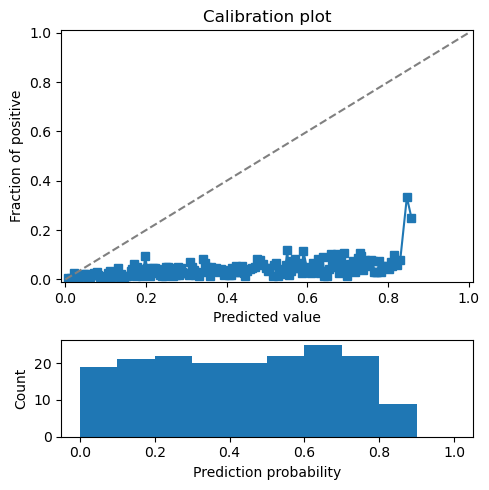

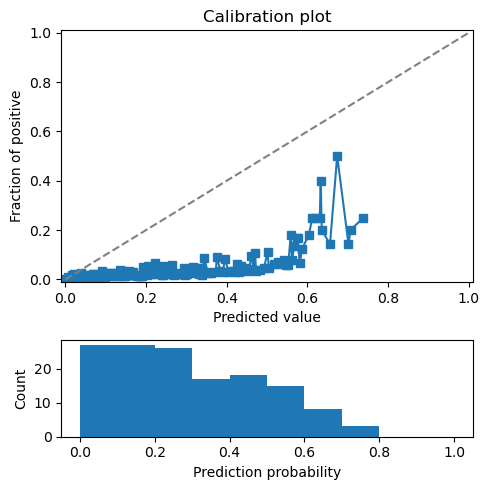

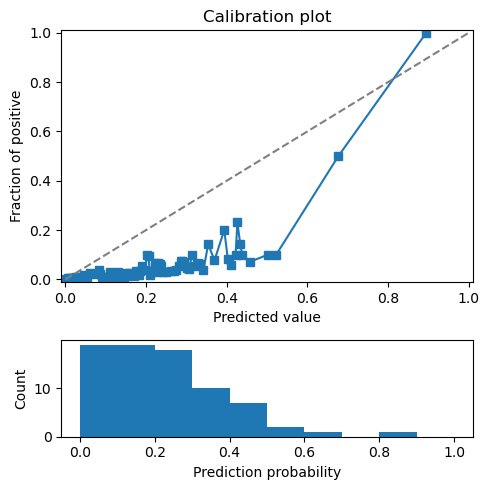

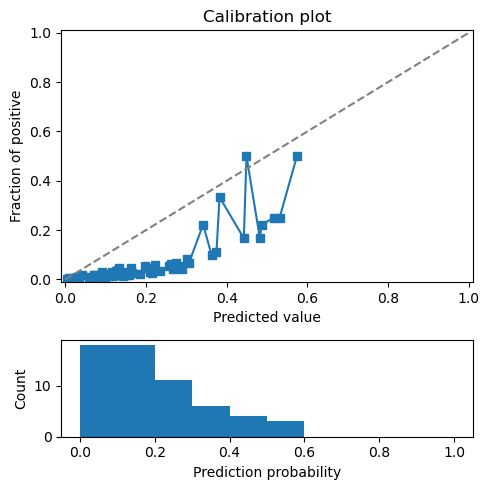

In [98]:
plot1 = plotter(p1_, y1_)
plot2 = plotter(p2_, y2_)
plot3 = plotter(p3_, y3_)
plot4 = plotter(p4_, y4_)

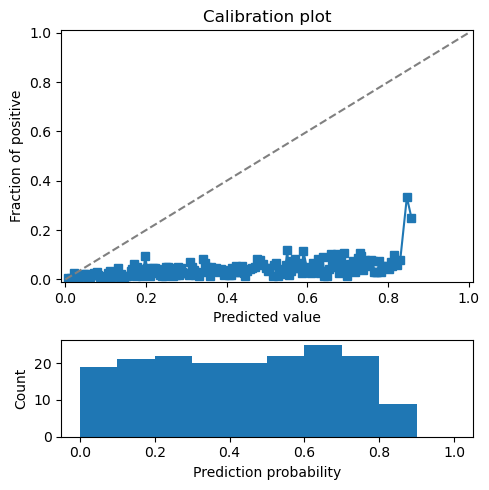

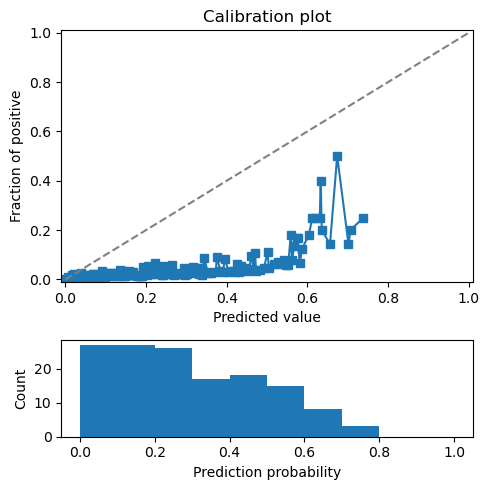

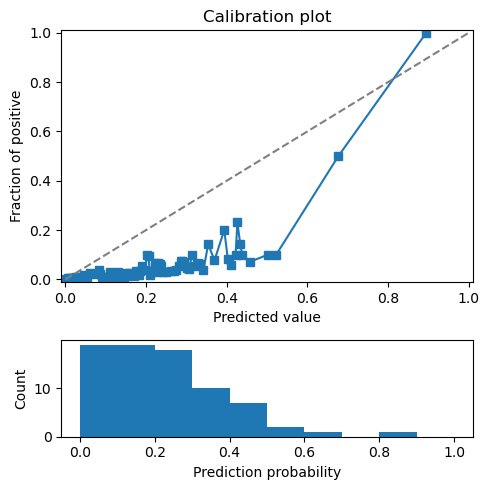

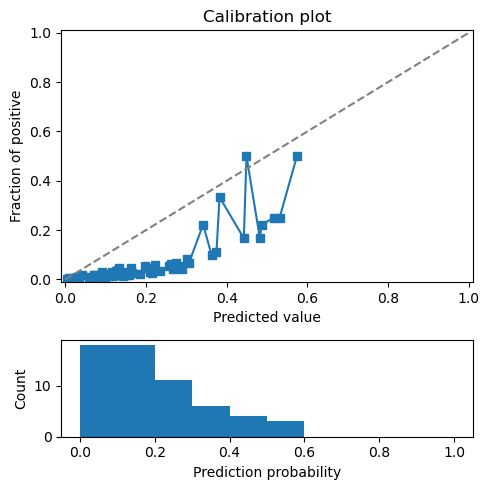

In [105]:
fig_folder = 'C:/Users/VHANYNHeT/Desktop/PI04/Figures/12_16'
plot1 = plotter(p1_, y1_)
plot1.savefig(os.path.join(fig_folder, 'cal1.png'), bbox_inches='tight')
plot2 = plotter(p2_, y2_)
plot2.savefig(os.path.join(fig_folder, 'cal2.png'), bbox_inches='tight')
plot3 = plotter(p3_, y3_)
plot3.savefig(os.path.join(fig_folder, 'cal3.png'), bbox_inches='tight')
plot4 = plotter(p4_, y4_)
plot4.savefig(os.path.join(fig_folder, 'cal4.png'), bbox_inches='tight')


In [56]:
import sklearn
from sklearn.metrics import confusion_matrix

fig_folder = 'C:/Users/VHANYNHeT/Desktop/PI04/Figures/New'
#plot1.savefig(os.path.join(fig_folder, 'recal1.png'), bbox_inches='tight')
#plot2.savefig(os.path.join(fig_folder, 'recal2.png'), bbox_inches='tight')
#plot3.savefig(os.path.join(fig_folder, 'recal3.png'), bbox_inches='tight')
#plot4.savefig(os.path.join(fig_folder, 'recal4.png'), bbox_inches='tight')


In [99]:
[sklearn.metrics.roc_auc_score(tgold4,  tp4 , average = 'samples'),
sklearn.metrics.roc_auc_score(tgold3,  tp3 , average = 'samples'),
sklearn.metrics.roc_auc_score(tgold2,  tp2 , average = 'samples'),
sklearn.metrics.roc_auc_score(tgold1,  tp1 , average = 'samples')]


[0.72329760776883, 0.707329131133358, 0.6747684821540783, 0.67034045056601]

In [100]:
( confusion_matrix (tgold1,  cal_1>.5) )

array([[11320,  4267],
       [  244,   227]], dtype=int64)

In [101]:
( confusion_matrix (tgold2,  cal_2>.5) )

array([[13204,   748],
       [  186,    33]], dtype=int64)

In [102]:
( confusion_matrix (tgold3,  cal_3>.5) )

array([[12447,   139],
       [  149,     4]], dtype=int64)

In [103]:
( confusion_matrix (tgold4,  cal_4>.5) )

array([[10503,    52],
       [   93,     3]], dtype=int64)

In [111]:
( confusion_matrix (tgold1,  cal_1**.5>.5) )

array([[7430, 8157],
       [ 111,  360]], dtype=int64)

In [110]:
( confusion_matrix (tgold2,  cal_2**.5>.5) )

array([[10223,  3729],
       [  116,   103]], dtype=int64)

In [108]:
( confusion_matrix (tgold3,  cal_3**.5>.5) )

array([[11490,  1096],
       [  117,    36]], dtype=int64)

In [106]:
( confusion_matrix (tgold4,  cal_4**.5>.5) )

array([[9896,  659],
       [  75,   21]], dtype=int64)

(array([22956.,  7498.,  5102.,  4208.,  3663.,  3274.,  2545.,  2106.,
         1678.,   529.]),
 array([0.00210476, 0.0995985 , 0.19709223, 0.29458597, 0.3920797 ,
        0.48957344, 0.58706717, 0.68456091, 0.78205464, 0.87954838,
        0.97704211]),
 <BarContainer object of 10 artists>)

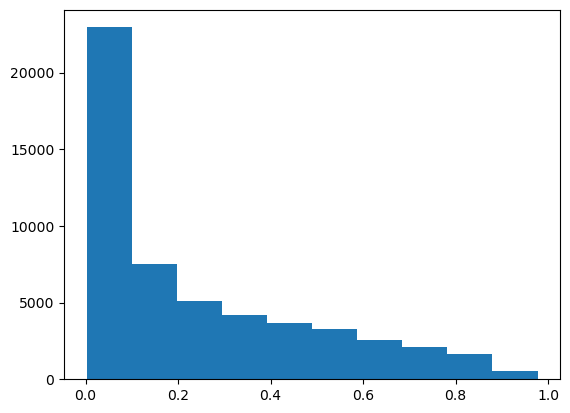

In [704]:
pc = temp_pred2(alpha_0_1234, lo1234 )
plt.hist(pc)

In [705]:
alpha_t_1234  = weighted_temp2_scaling(  lo1234 , y1234,  wts1234)
pt = temp_pred2(alpha_t_1234, tlo1234 )

In [706]:
ct1 = ( pt [tti==1])**k
ct2 = ( pt [tti==2]) **k
ct3 = ( pt [tti==3]) **k
ct4 =  (pt [tti==4])**k

In [707]:
def get_calibration_curve(golds_for_eval,Probs_for_eval):
    prob_true, prob_pred = calibration_curve(golds_for_eval, Probs_for_eval, n_bins=250)
    p_ = prob_pred [prob_true>0]
    y_ = prob_true [prob_true>0]
    return y_, p_


In [708]:

y01, p01 = get_calibration_curve(M_test1['golds'], ct1  )
y02, p02 = get_calibration_curve(M_test2['golds'], ct2  )
y03, p03 =get_calibration_curve(M_test3['golds'], ct3)
y04, p04 = get_calibration_curve(M_test4['golds'], ct4  )


In [709]:
len(y01)
len(p01)

183

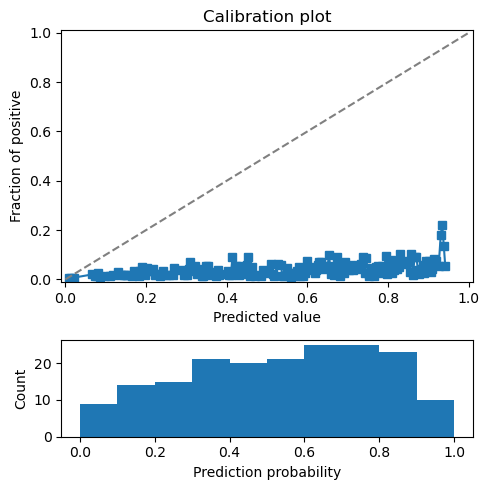

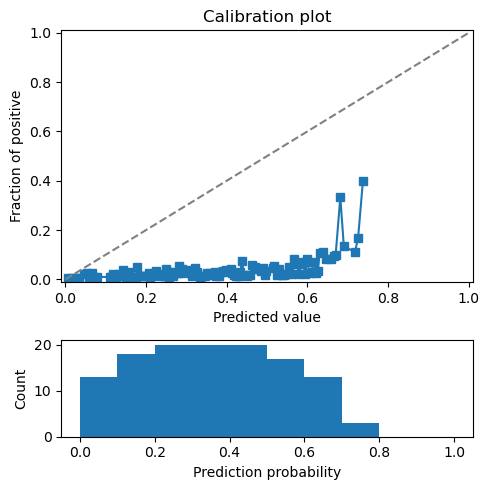

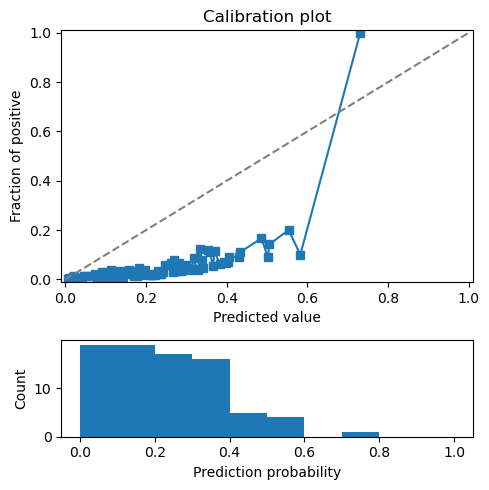

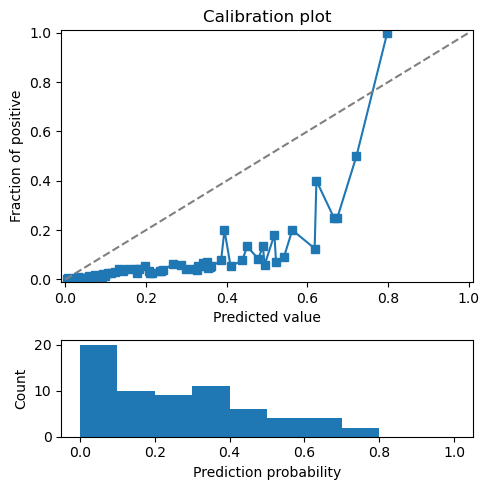

In [710]:
plot1 = plotter(p01, y01)
plot2 = plotter(p02, y02)
plot3 = plotter(p03, y03)
plot4 = plotter(p04, y04)

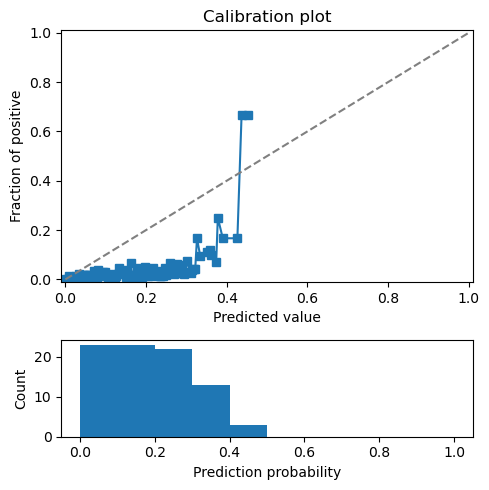

In [632]:
p4_ = p4 [y4>0]
y4_ = y4 [y4>0]
p3_ = p3 [y3>0]
y3_ = y3 [y3>0]
p2_ = p2 [y2>0]
y2_ = y2 [y2>0]
p1_ = p1 [y1>0]
y1_ = y1 [y1>0]

In [644]:
k = 1
wp1 = ( pc [ti==1])**k
wp2 = ( pc [ti==2]) **k
wp3 = ( pc [ti==3]) **k
wp4 =  (pc [ti==4])**k
np1 =  ((1-pc) [ti==1])**k
np2 =  ((1-pc) [ti==2])**k
np3 =  ((1-pc) [ti==3])**k
np4 =  ((1-pc) [ti==4])**k

In [ ]:

y01, p01 = calibration_curve(M_test1['golds'], wp1 , n_bins = 600)
y02, p02 = calibration_curve(M_test2['golds'], wp2 , n_bins = 600)
y03, p03 =calibration_curve(M_test3['golds'], wp3 , n_bins = 300)
y04, p04 = calibration_curve(M_test4['golds'], wp4 , n_bins = 200)
